# Waveguide coupler (layout and simulation)

The step by step process is the same as the previous notebook:
1. Draw a waveguide coupler and save it in a .gds file.
2. Load the layout using Meep.
3. Setup simulation environment.
4. Simulate FDTD and visualize results.
5. Compute loss and reflection of the bend.

## Why is this important?

- FDTD simulations take a long time.
- This can be compensated by breaking up the simulation in smaller parts
- For example, in order to simulate an add-drop microring resonator, we can break it up in bent waveguides and couplers, like in the image below.
!['Add/Drop Microring Resonator'](images/add_drop_ring.svg)

Last notebook, we simulated a bent waveguide and captured the results in an S-matrix. In this notebook, we will simulate the waveguide coupler. After that, the S-matrices can be used together to compute the response of the microring resonator.

## Simulation 1

- This device has 4 ports, and therefore it will require a 4x4 S-matrix. 
- It will take multiple FDTD simulations in order to obtain the full 4x4 S matrix.
- For example, consider the following source/port configuration:
<img alt="Waveguide coupler with source at port 1" src="images/waveguide_coupler_source1.svg" style="width: 50%">
- Each simulation ordinarily yields 4 S-numbers, but because of the symmetry of this device, the S values upon swapping ports 1↔3 and 2↔4 should remain the same. For example, $S_{23} = S_{41}$ for all frequencies.

In this notebook, we will prepare an FDTD simulation with the source at port 1.

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Debug info
print("Meep version:", mp.__version__)

Using MPI version 3.1, 1 processes
Meep version: 1.12.0


In [2]:
import pya
import numpy as np

SIM_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE = pya.LayerInfo(10, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)
MEEP_PORT3 = pya.LayerInfo(22, 0)
MEEP_PORT4 = pya.LayerInfo(23, 0)

## Simulation Parameters

In [179]:
ring_radius = 3 # um
ring_width = 0.5 # um
pml_width = 1.0 # um
gap = 0.2 # um
src_port_gap = 0.2 # um
straight_wg_length = pml_width + 1 # um

# Simulation resolution
res = 100        # pixels/μm

## Step 1. Drawing a waveguide coupler and saving into a temporary .gds file

In [180]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box
from tempfile import NamedTemporaryFile
from math import sqrt

# Create a temporary filename
temp_file = NamedTemporaryFile(delete=False, suffix='.gds')
filename = temp_file.name
# temp_file = None
# filename = "test.gds"

# Clean existing file
!rm {filename}

# Instantiate a layout and a top cell
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

sqrt2 = sqrt(2)

# Unit vectors
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)
e45 = (ex + ey) / sqrt2
e135 = (-ex + ey) / sqrt2

# Draw circular bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - straight_wg_length*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, 
                           -straight_wg_length * ey - ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width * 4.0


# Draw add/drop waveguide

coupling_point = (ring_radius + gap + ring_width) * e45 - ring_radius * ey
add_drop_length = (ring_radius + gap + ring_width) * sqrt2
layout_waveguide(TOP, Si, [coupling_point + (add_drop_length + 0.4) * e135,
                           coupling_point - (add_drop_length + 0.4) * e135],
                ring_width)


# Source at port 1
layout_path(TOP, MEEP_SOURCE, [coupling_point - port_size/2*ex + (add_drop_length / 2 + src_port_gap) * e135, 
                               coupling_point + port_size/2*ex + (add_drop_length / 2 + src_port_gap) * e135], 0)

# Source at port 2 (alternative)
# layout_path(TOP, MEEP_SOURCE, [-port_size/2*ey - src_port_gap*ex, port_size/2*ey - 0.2*ex], 0)

# Port 1
layout_path(TOP, MEEP_PORT1,   [coupling_point - port_size/2*ex + (add_drop_length / 2) * e135, 
                                coupling_point + port_size/2*ex  + (add_drop_length / 2) * e135], 0)

# Port 2
layout_path(TOP, MEEP_PORT2,   [-port_size/2*ey, port_size/2*ey], 0)

# Port 3
layout_path(TOP, MEEP_PORT3,   [coupling_point - port_size/2*ey - (add_drop_length / 2) * e135, 
                                coupling_point + port_size/2*ey - (add_drop_length / 2) * e135], 0)
# Port 4
layout_path(TOP, MEEP_PORT4,   [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex, 
                                -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

# Draw simulation region
layout_box(TOP, SIM_CELL, 
           -1.0*ring_radius*ey - (pml_width + src_port_gap) * (ex + ey), # Bottom left point 
           coupling_point + (add_drop_length / 2 + src_port_gap) * e45 + pml_width * (ex + ey),  # Top right point
           ex)

# Write to file
layout.write(filename)
layout.write('test.gds')
print(f"Produced file {filename}.")
!ls -lh {filename}

Produced file /tmp/tmp5hvpm_rs.gds.
-rw-r--r-- 1 tlima grad 1.7K Feb 25 13:17 /tmp/tmp5hvpm_rs.gds


## Step 2. Load gds file into meep

### Visualization and simulation

If you choose a normal filename (not temporary), you can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating:

In [181]:
def round_vector(vector, decimal_places=3):
    x = round(vector.x, decimal_places)
    y = round(vector.y, decimal_places)
    z = round(vector.z, decimal_places)
    return mp.Vector3(x, y, z)

In [182]:
gdsII_file = filename
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21
PORT3_LAYER = 22
PORT4_LAYER = 23

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

cell_zmax =  0
cell_zmin =  0
si_zmax = 0
si_zmin = 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
# WARNING: Once the file is loaded, the prism contents is cached and cannot be reloaded.
# SOLUTION: Use a different filename or restart the kernel

si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)
p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, si_zmin, si_zmax)
p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              direction=mp.NO_DIRECTION,
                              eig_kpoint=mp.Vector3(1, -1, 0), # -45 degree angle
                              eig_band=1,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
#                     subpixel_maxeval=10,
#                     subpixel_tol=0.1,
                    cell_size=cell.size,
                    geometry_center=round_vector(cell.center,2),
#                     geometry_center=mp.Vector3(2.20, -0.79,0),
                    boundary_layers=[mp.PML(pml_width)],
                    sources=sources,
                    geometry=si_layer)

# Delete file created in previous cell

import os
if temp_file:
    temp_file.close()
    os.unlink(filename)

## Step 3. Setup simulation environment

This will load the python-defined parameters from the previous cell and instantiate a fast, C++ based, simulation environment using meep. It will also compute the eigenmode of the source, in preparation for the FDTD simulation.

In [183]:
sim.reset_meep()

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, df, 10, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, df, 10, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcen, df, 10, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcen, df, 10, mp.ModeRegion(volume=p4))

# Let's store the frequencies that were generated by this mode monitor
mode1_freqs = np.array(mp.get_eigenmode_freqs(mode1))
mode2_freqs = np.array(mp.get_eigenmode_freqs(mode2))
mode3_freqs = np.array(mp.get_eigenmode_freqs(mode3))
mode4_freqs = np.array(mp.get_eigenmode_freqs(mode4))

sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000382185 s
Working in 2D dimensions.
Computational cell is 6.81 x 6.81 x 0 with resolution 100
     prism, center = (1.90628,-1.09372,0)
          height 0, axis (0,0,1), 122 vertices:
          (2.75,-3,0)
          (2.749,-2.933,0)
          (2.747,-2.865,0)
          (2.743,-2.798,0)
          (2.737,-2.73,0)
          (2.729,-2.663,0)
          (2.72,-2.596,0)
          (2.71,-2.53,0)
          (2.697,-2.464,0)
          (2.683,-2.397,0)
          (2.668,-2.332,0)
          (2.632,-2.202,0)
          (2.611,-2.137,0)
          (2.589,-2.074,0)
          (2.566,-2.01,0)
          (2.541,-1.948,0)
          (2.514,-1.886,0)
          (2.486,-1.824,0)
          (2.456,-1.764,0)
          (2.425,-1.704,0)
          (2.393,-1.645,0)
          (2.359,-1.586,0)
          (2.287,-1.472,0)
          (2.209,-1.362,0)
          (2.168,-1.308,0)
          (2.126,-1.255,0)
          (2.038,-1.153,0)
          (1.992,-1.104

### Verify if there are numerical errors.
- You should see a clean black and white plot.
- If there are other weird structures, try increasing the resolution.

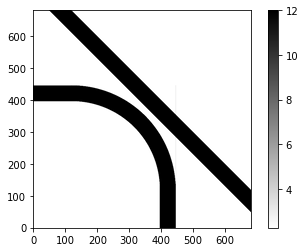

In [184]:
eps_data = sim.get_array(center=cell.center, size=cell.size, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary', origin='lower')
plt.colorbar()
plt.show()

### Verify that the structure makes sense.

Things to check:
- Are the sources and ports outside the PML?
- Are dimensions correct?
- Is the simulation region unnecessarily large?

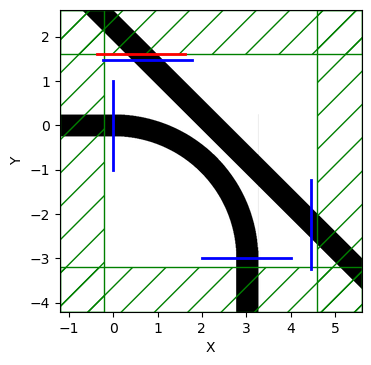

In [185]:
# If there is a warning that reads "The specified user volume
# is larger than the simulation domain and has been truncated",
# It has to do with some numerical errors between python and meep.
# Ignore.
# sim.init_sim()

f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. Later, we will put this notebook's code into a script and run it in parallel.

## Step 4. Simulate FDTD and Animate results

More detailed meep documentation available [here](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#transmittance-spectrum-of-a-waveguide-bend).

In [186]:
# Set to true to compute animation (may take a lot of memory)
compute_animation = True

In [187]:
# Setup and run the simulation

# The following line defines a stopping condition depending on the square
# of the amplitude of the Ez field at the port 2.
print(f"Stop condition: decay to 0.1% of peak value in the last {2.0/df:.1f} time units.")
stop_condition = mp.stop_when_fields_decayed(2.0/df,mp.Ez,p2.center,1e-3)
if compute_animation:
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
    sim.run(mp.at_every(1,animate), until_after_sources=stop_condition)
    plt.close()
else:
    sim.run(until_after_sources=stop_condition)

Stop condition: decay to 0.1% of peak value in the last 15.5 time units.


/home/ELE559/anaconda3/envs/all_tools/lib/python3.7/site-packages/meep/visualization.py:197: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn('The specified user volume is larger than the simulation domain and has been truncated.')


on time step 376 (time=1.88), 0.0106476 s/step


/home/ELE559/anaconda3/envs/all_tools/lib/python3.7/site-packages/meep/visualization.py:197: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn('The specified user volume is larger than the simulation domain and has been truncated.')


on time step 1029 (time=5.145), 0.00612757 s/step
on time step 1691 (time=8.455), 0.00604794 s/step
on time step 2356 (time=11.78), 0.00601961 s/step
on time step 3011 (time=15.055), 0.00610869 s/step
field decay(t = 15.505): 1.6275283764504445e-10 / 1.6275283764504445e-10 = 1.0
on time step 3676 (time=18.38), 0.00601976 s/step
on time step 4342 (time=21.71), 0.00601294 s/step
on time step 5005 (time=25.025), 0.00603868 s/step
on time step 5670 (time=28.35), 0.006016 s/step
field decay(t = 31.01): 2.165800723822152e-06 / 2.165800723822152e-06 = 1.0
on time step 6333 (time=31.665), 0.00603361 s/step
on time step 6999 (time=34.995), 0.00601325 s/step
on time step 7661 (time=38.305), 0.00604626 s/step
on time step 8326 (time=41.63), 0.00601913 s/step
on time step 8991 (time=44.955), 0.00601684 s/step
field decay(t = 46.515): 1.2175114634136154e-05 / 1.2175114634136154e-05 = 1.0
on time step 9652 (time=48.26), 0.00605538 s/step
on time step 10316 (time=51.58), 0.00602433 s/step
on time ste

### Visualize results

Things to check:
- Was the simulation time long enough for the pulse to travel through port2 in its entirety? Given the automatic stop condition, this should be the case.

In [205]:
from IPython.display import Video, display
animate.to_mp4(10, 'media/bend.mp4')
display(Video('media/bend.mp4'))

Generating MP4...


## Step 5. Compute loss and reflection of the bend

In [198]:
# Every mode monitor measures the power flowing through it in either the forward or backward direction
kpoint135 = mp.Vector3(x=1).rotate(mp.Vector3(z=1), np.radians(-45))

eig_mode1 = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY, direction=mp.NO_DIRECTION, kpoint_func=lambda f,n: kpoint135)
eig_mode2 = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY)
eig_mode3 = sim.get_eigenmode_coefficients(mode3, [1], eig_parity=mp.NO_PARITY, direction=mp.NO_DIRECTION, kpoint_func=lambda f,n: kpoint135)
eig_mode4 = sim.get_eigenmode_coefficients(mode4, [1], eig_parity=mp.NO_PARITY)

# First, we need to figure out which direction the "dominant planewave" k-vector is
# We can pick the first frequency (0) for that, assuming that for all simulated frequencies,
# The dominant k-vector will point in the same direction.
k1 = eig_mode1.kdom[0]
k2 = eig_mode2.kdom[0]
k3 = eig_mode3.kdom[0]
k4 = eig_mode4.kdom[0]

# eig_mode.alpha[0,0,0] corresponds to the forward direction, whereas
# eig_mode.alpha[0,0,1] corresponds to the backward direction

# For port 1, we are interested in the -y direction, so if k1.y is positive, select 1, otherwise 0
idx = (k1.y > 0) * 1
p1_thru_coeff = eig_mode1.alpha[0,:,idx]
p1_reflected_coeff = eig_mode1.alpha[0,:,1-idx]

# For port 3, we are interestred in the +x direction
idx = (k3.x < 0) * 1
p3_thru_coeff = eig_mode3.alpha[0,:,idx]
p3_reflected_coeff = eig_mode3.alpha[0,:,1-idx]

# transmittance
S31 = p3_thru_coeff/p1_thru_coeff
S11 = p1_reflected_coeff/p1_thru_coeff
trans = abs(S31)**2
reflected = abs(S11)**2

print("----------------------------------")
print(f"Parameters: radius={ring_radius:.1f}")
print(f"Frequencies: {mode1_freqs}")
print(f"Transmitted fraction: {trans}")
print(f"Reflected fraction: {reflected}")

MPB solved for omega_1(0.707107,-1.41421,0) = 0.338155 after 19 iters
MPB solved for omega_1(1.31728,-2.63456,0) = 0.57859 after 11 iters
MPB solved for omega_1(1.32249,-2.64498,0) = 0.580645 after 8 iters
MPB solved for omega_1(1.32249,-2.64498,0) = 0.580645 after 1 iters
Dominant planewave for band 1: (1.322491,-1.322491,0.000000)
MPB solved for omega_1(0.707107,-1.41421,0) = 0.338155 after 17 iters
MPB solved for omega_1(1.35336,-2.70672,0) = 0.592829 after 11 iters
MPB solved for omega_1(1.35881,-2.71763,0) = 0.594982 after 8 iters
MPB solved for omega_1(1.35881,-2.71763,0) = 0.594982 after 1 iters
Dominant planewave for band 1: (1.358813,-1.358813,0.000000)
MPB solved for omega_1(0.707107,-1.41421,0) = 0.338155 after 16 iters
MPB solved for omega_1(1.38943,-2.77887,0) = 0.607075 after 11 iters
MPB solved for omega_1(1.39511,-2.79023,0) = 0.609319 after 8 iters
MPB solved for omega_1(1.39511,-2.79023,0) = 0.609319 after 1 iters
Dominant planewave for band 1: (1.395114,-1.395114,0.0

MPB solved for omega_1(3.00779,-1.50389,0) = 0.65233 after 8 iters
MPB solved for omega_1(3.00778,-1.50389,0) = 0.65233 after 1 iters
Dominant planewave for band 1: (1.503892,-1.503892,0.000000)
MPB solved for omega_1(1.41421,-0.707107,0) = 0.338155 after 17 iters
MPB solved for omega_1(3.06747,-1.53374,0) = 0.664144 after 12 iters
MPB solved for omega_1(3.08022,-1.54011,0) = 0.666667 after 8 iters
MPB solved for omega_1(3.08022,-1.54011,0) = 0.666667 after 1 iters
Dominant planewave for band 1: (1.540110,-1.540110,0.000000)
MPB solved for omega_1(1.41421,-0.707107,0) = 0.338155 after 17 iters
MPB solved for omega_1(3.13963,-1.56981,0) = 0.678431 after 12 iters
MPB solved for omega_1(3.15261,-1.57631,0) = 0.681004 after 8 iters
MPB solved for omega_1(3.15261,-1.57631,0) = 0.681004 after 1 iters
Dominant planewave for band 1: (1.576306,-1.576306,0.000000)
MPB solved for omega_1(1.41421,-0.707107,0) = 0.338155 after 15 iters
MPB solved for omega_1(3.21178,-1.60589,0) = 0.692727 after 12 

In [204]:
#These should be oblique
k1, k3

(Vector3<1.3224906945535888, -1.3224906945535886, 0.0>,
 Vector3<1.322490694553588, -1.3224906945535877, 0.0>)

# Milestones

Goal: Compute the transmission profile for bend radii between 1.5um and 10um. 

- Q: Is the reflection significant for any radius? What explain the loss?
- Q: What is the formula total size of the simulation region? How many pixels are there?
- Q: If each pixel can host 3-dimensional E-field and H-field vectors with 64bit complex float stored in each dimension, how many megabytes of data needs to be stored at each time step? Is it feasible to save all this information throughout the FDTD simulation?
- Bonus: Collect the simulation runtime for each radius. How does it change with different radii?
- Bonus: At what resolution does the accuracy of the simulation start degrading? In other words, if halving the resolution only results in a 1% relative difference in the most important target metric, it is still a good resolution.

In [200]:
S31 = p3_thru_coeff/p1_thru_coeff
S11 = p1_reflected_coeff/p1_thru_coeff

In [201]:
S31_mag = np.abs(S31)
S31_phase = np.unwrap(np.angle(S31))

S11_mag = np.abs(S11)
S11_phase = np.unwrap(np.angle(S11))

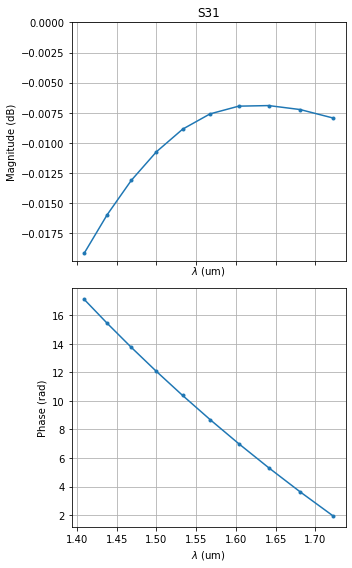

In [202]:
# Plot S21
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S31_mag), '.-')
ax1.set_title("S31")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S31_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

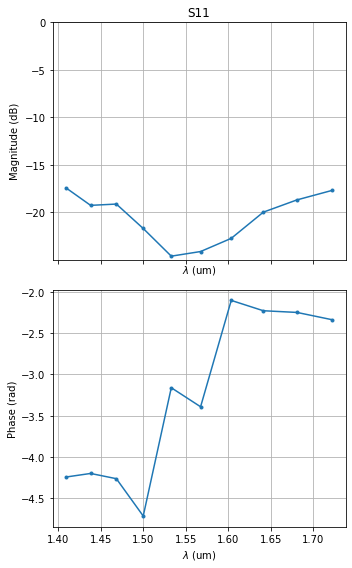

In [203]:
# Plot S11
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S11_mag), '.-')
ax1.set_title("S11")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S11_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()